<a href="https://colab.research.google.com/github/Abu-shanto/Machine-Learning-/blob/main/Brain_Tumour_Detect_Concatenation_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
# Set your data paths
train_data_path = '/content/drive/MyDrive/brain_tumor_dataset train'
test_data_path = '/content/drive/MyDrive/brain tumor dataset test'

# Define image dimensions
img_width, img_height = 224, 224  # Adjust to your chosen input size

# Load and preprocess images
def preprocess_data(data_path):
    images = []
    labels = []

    for folder_name in os.listdir(data_path):
        label = folder_name  # Assuming folder names are the labels
        folder_path = os.path.join(data_path, folder_name)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Preprocess train and test data
train_images, train_labels = preprocess_data(train_data_path)
test_images, test_labels = preprocess_data(test_data_path)

# Split the data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Normalize pixel values to [0, 1]
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

print("Train data shape:", train_images.shape)
print("Validation data shape:", val_images.shape)
print("Test data shape:", test_images.shape)


Train data shape: (202, 224, 224, 3)
Validation data shape: (51, 224, 224, 3)
Test data shape: (253, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import numpy as np

# Create models without classification layers
base_inception = InceptionV3(weights='imagenet', include_top=False)
base_resnet = ResNet50(weights='imagenet', include_top=False)

# Global average pooling layer
pooling_layer = GlobalAveragePooling2D()

# Extract features using InceptionV3 and ResNet50
train_features_inception = base_inception.predict(train_images)
train_features_resnet = base_resnet.predict(train_images)

val_features_inception = base_inception.predict(val_images)
val_features_resnet = base_resnet.predict(val_images)

test_features_inception = base_inception.predict(test_images)
test_features_resnet = base_resnet.predict(test_images)

# Apply global average pooling to extracted features
train_features_inception = pooling_layer(train_features_inception)
train_features_resnet = pooling_layer(train_features_resnet)

val_features_inception = pooling_layer(val_features_inception)
val_features_resnet = pooling_layer(val_features_resnet)

test_features_inception = pooling_layer(test_features_inception)
test_features_resnet = pooling_layer(test_features_resnet)

# Verify dimensions of the extracted features
print("InceptionV3 train features shape:", train_features_inception.shape)
print("ResNet50 train features shape:", train_features_resnet.shape)

# Continue with Step 3: Concatenate Features

8/8 [==============================] - 54s 7s/step
InceptionV3 train features shape: (202, 2048)
ResNet50 train features shape: (202, 2048)


In [ ]:
import numpy as np

# Concatenate the features
train_concatenated_features = np.concatenate((train_features_inception, train_features_resnet), axis=-1)
val_concatenated_features = np.concatenate((val_features_inception, val_features_resnet), axis=-1)
test_concatenated_features = np.concatenate((test_features_inception, test_features_resnet), axis=-1)

# Verify dimensions of concatenated features
print("Concatenated train features shape:", train_concatenated_features.shape)

Concatenated train features shape: (202, 4096)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier on the concatenated training features
svm_classifier.fit(train_concatenated_features, train_labels)

# Predict on the validation and test data
val_predictions = svm_classifier.predict(val_concatenated_features)
test_predictions = svm_classifier.predict(test_concatenated_features)

# Calculate accuracy and other metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

# Generate a classification report
print("Validation Classification Report:")
print(classification_report(val_labels, val_predictions))

print("Test Classification Report:")
print(classification_report(test_labels, test_predictions))


Validation Accuracy: 0.8627450980392157
Test Accuracy: 0.9723320158102767
Validation Classification Report:
              precision    recall  f1-score   support

          no       0.81      0.85      0.83        20
         yes       0.90      0.87      0.89        31

    accuracy                           0.86        51
   macro avg       0.85      0.86      0.86        51
weighted avg       0.86      0.86      0.86        51

Test Classification Report:
              precision    recall  f1-score   support

          no       0.96      0.97      0.96        98
         yes       0.98      0.97      0.98       155

    accuracy                           0.97       253
   macro avg       0.97      0.97      0.97       253
weighted avg       0.97      0.97      0.97       253



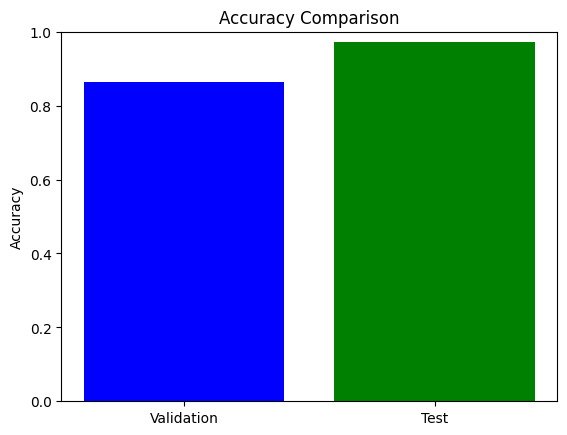

Validation Precision: 0.8645191409897294
Validation Recall: 0.8627450980392157
Validation F1-score: 0.8632938981270237
Test Precision: 0.9724147174740061
Test Recall: 0.9723320158102767
Test F1-score: 0.9723574689194485


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Generate an accuracy graph
x_labels = ['Validation', 'Test']
accuracy_scores = [val_accuracy, test_accuracy]

plt.bar(x_labels, accuracy_scores, color=['blue', 'green'])
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

# Calculate precision, recall, and F1-score
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')

test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')

print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-score:", val_f1)

print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1)
